# A. INTRODUCTION

Olist is a Brazilian e-commerce platform that connects small and medium-sized businesses with large online marketplaces, enabling them to sell their products to a wider audience. By providing a centralized solution, Olist simplifies the selling process for merchants, offering tools for product listing, inventory management, and order fulfillment. The platform also handles logistics and customer service, ensuring a seamless shopping experience for buyers. With a focus on empowering small businesses, Olist allows sellers to leverage the reach of prominent marketplaces while maintaining control over their operations. This innovative approach has made Olist a key player in the e-commerce ecosystem, fostering growth and accessibility for merchants across Brazil.

## Loading and Preparing the Dataset

In [1]:
#import library
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sqlite3 as sql
import nltk
from wordcloud import WordCloud
import re
from nltk.corpus import stopwords

In [2]:
db_connection = sql.connect("D:/OneDrive/Personal Project/Brazil e-commerce/olist.sqlite")

In [3]:
def view_table(table, limit):
    query = f"""
        SELECT *
        FROM {table}
        LIMIT {limit}
    """
    return pd.read_sql_query(query, db_connection)
view_table('orders', 5).iloc[:,3:]

,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
0,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18 00:00:00
1,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13 00:00:00
2,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04 00:00:00
3,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15 00:00:00
4,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26 00:00:00


# B. EXPLORATORY DATA ANALYSIS (EDA)

## I. Order Analysis

Firstly, we want to see the number of orders per day. We use SQL command to retrieve data, and using matplotlib to visualize it.

Text(0.5, 1.0, 'Number of orders per day')

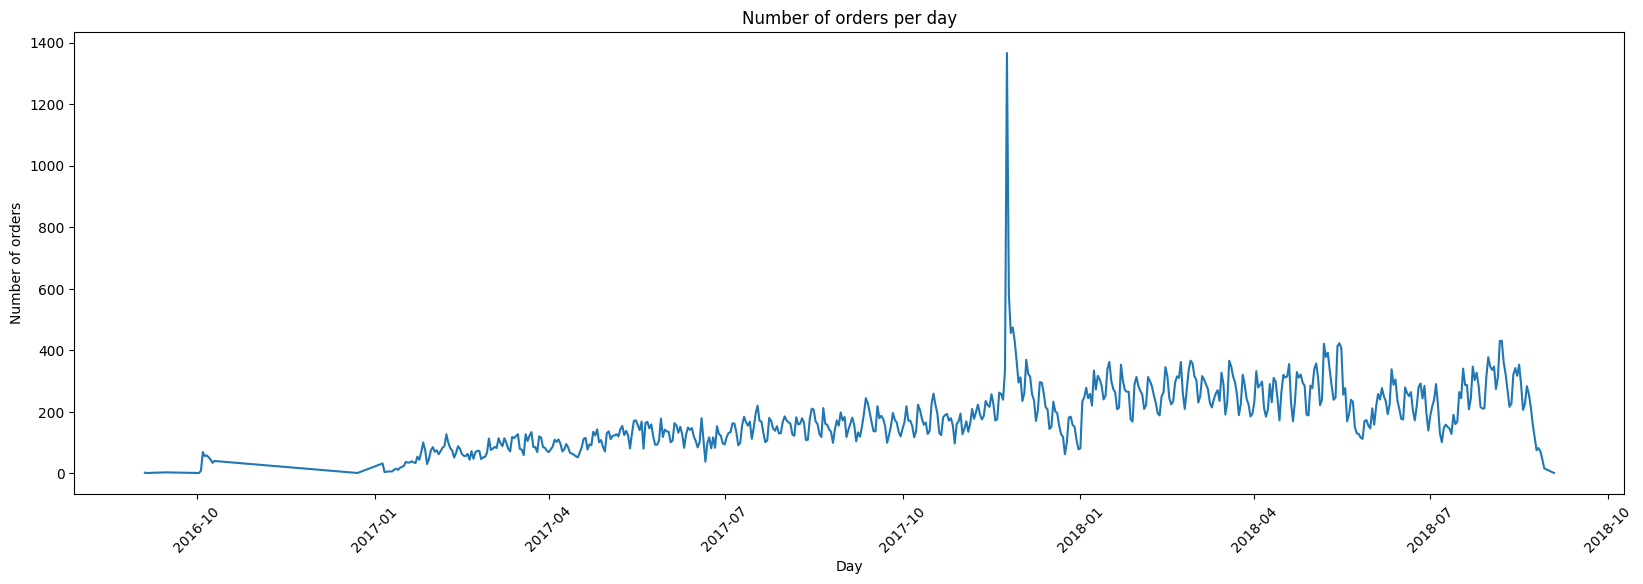

In [4]:
#SQL command to get the number of orders per day and total revenue per day
order_revenue_per_days = """
select
	DAte(o.order_purchase_timestamp) as Day,
	COUNT(*) as "Number of orders",
	sum(oi.price+oi.freight_value) as "Revenue"
from orders o
join order_items oi on oi.order_id = o.order_id 
group by Day
"""
df_or_per_day = pd.read_sql_query(order_revenue_per_days, db_connection)
df_or_per_day['Day'] = pd.to_datetime(df_or_per_day['Day'])
#Ploting
fig, ax = plt.subplots(1, 1, figsize=(20,6))
ax.plot(df_or_per_day['Day'], df_or_per_day['Number of orders']) 
ax.set_xlabel('Day') 
ax.set_ylabel('Number of orders') 
ax.tick_params(axis='x', rotation=45) 
ax.set_title('Number of orders per day')

Order volume exhibited significant growth throughout the year, culminating in a peak during the Christmas Eve event at the end of 2017. The average order count hovered around 200, with fluctuations ranging from 100 to 400 orders. Prior to January 2017, order activity was virtually nonexistent. Consequently, for subsequent analyses, these initial data points should be excluded.

We hypothesize that consumer purchasing behavior may exhibit variations across weekdays and throughout the day. Specifically, we're interested in determining whether:

**1. Weekend shopping patterns:** Do consumers tend to make more purchases on weekends?

**2. Nighttime purchasing:** Is there an increase in order volume during evening hours when consumers have more free time to browse and place orders on the Olist platform?

To investigate these hypotheses, we will extract the number of orders for each weekday and for every hour of the day

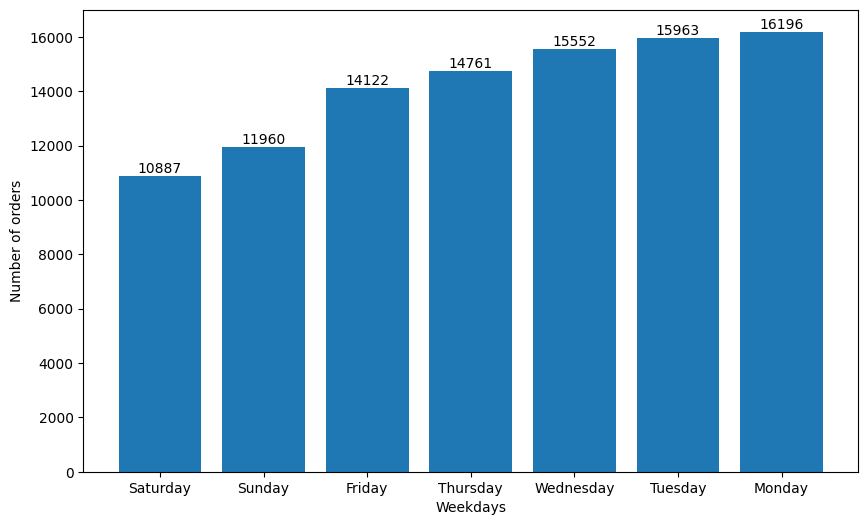

In [5]:
#Number of orders per weekdays
order_per_weekdays = """ 
select 
	CASE strftime('%w',o.order_purchase_timestamp)
		when "0" then "Sunday"
		when "1" then "Monday"
		when "2" then "Tuesday"
		when "3" then "Wednesday"
		when "4" then "Thursday"
		when "5" then "Friday"
		when "6" then "Saturday"
		end as "Weekdays",
		COUNT(*) as "Number of order" 
from orders o 
group by Weekdays
order by "Number of order" ASC
"""
df_or_wd = pd.read_sql_query(order_per_weekdays, db_connection)
plt.figure(figsize=(10,6))
bar_wd = plt.bar(df_or_wd['Weekdays'], df_or_wd['Number of order'])
for bar in bar_wd:
  height = bar.get_height()
  plt.text(bar.get_x() + bar.get_width() / 2, height + 5, int(height), ha='center', va='bottom')
plt.xlabel('Weekdays')
plt.ylabel('Number of orders')
plt.show()

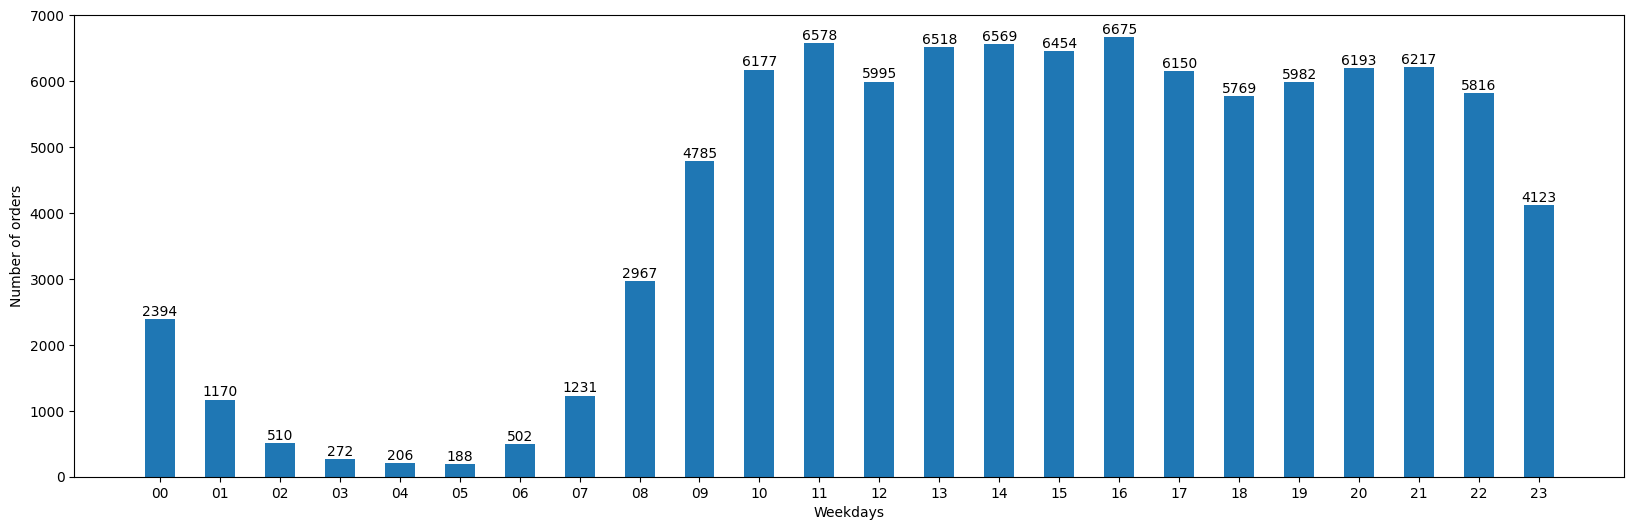

In [6]:
order_per_hour = """
select  strftime('%H',o.order_purchase_timestamp) as "Hour", count(*) as "Number of order"
from orders o
group by Hour
order by "Hour";
"""
df_or_h = pd.read_sql_query(order_per_hour, db_connection)
plt.figure(figsize=(20,6))
bar_h = plt.bar(df_or_h['Hour'], df_or_h['Number of order'],width=0.5)
for bar in bar_h:
  height = bar.get_height()
  plt.text(bar.get_x() + bar.get_width() / 2, height + 5, int(height), ha='center', va='bottom')
plt.xlabel('Weekdays')
plt.ylabel('Number of orders')
plt.show()

Our analysis reveals that Monday exhibited the highest total order volume, followed closely by Tuesday and Wednesday. Notably, weekend order activity was significantly lower than the beginning of the week. Furthermore, order volume demonstrated a diurnal pattern, with minimal activity during the overnight hours. Conversely, peak order periods were observed between 1:00 PM and 4:00 PM, and again around 9:00 PM.

To gain deeper insights, we will construct a matrix with two axes: weekdays and hours. This matrix will enable a granular examination of order frequency across different time periods within each day, identifying both peak and low-volume periods.

In [7]:
order_day_hour = """
WITH OrderDayHour AS (
    SELECT
        CASE STRFTIME('%w', order_purchase_timestamp)
            WHEN '1' THEN 'Mon'
            WHEN '2' THEN 'Tue'
            WHEN '3' THEN 'Wed'
            WHEN '4' THEN 'Thu'
            WHEN '5' THEN 'Fri'
            WHEN '6' THEN 'Sat'
            WHEN '0' THEN 'Sun'
        END AS day_of_week_name,
        CAST(STRFTIME('%w', order_purchase_timestamp) AS INTEGER) AS day_of_week_int,
        CAST(STRFTIME("%H", order_purchase_timestamp) AS INTEGER) AS hour
    FROM orders
)
SELECT
    day_of_week_name,
    COUNT(CASE WHEN hour = 0 THEN 1 END) AS "0",
    COUNT(CASE WHEN hour = 1 THEN 1 END) AS "1",
    COUNT(CASE WHEN hour = 2 THEN 1 END) AS "2",
    COUNT(CASE WHEN hour = 3 THEN 1 END) AS "3",
    COUNT(CASE WHEN hour = 4 THEN 1 END) AS "4",
    COUNT(CASE WHEN hour = 5 THEN 1 END) AS "5",
    COUNT(CASE WHEN hour = 6 THEN 1 END) AS "6",
    COUNT(CASE WHEN hour = 7 THEN 1 END) AS "7",
    COUNT(CASE WHEN hour = 8 THEN 1 END) AS "8",
    COUNT(CASE WHEN hour = 9 THEN 1 END) AS "9",
    COUNT(CASE WHEN hour = 10 THEN 1 END) AS "10",
    COUNT(CASE WHEN hour = 11 THEN 1 END) AS "11",
    COUNT(CASE WHEN hour = 12 THEN 1 END) AS "12",
    COUNT(CASE WHEN hour = 13 THEN 1 END) AS "13",
    COUNT(CASE WHEN hour = 14 THEN 1 END) AS "14",
    COUNT(CASE WHEN hour = 15 THEN 1 END) AS "15",
    COUNT(CASE WHEN hour = 16 THEN 1 END) AS "16",
    COUNT(CASE WHEN hour = 17 THEN 1 END) AS "17",
    COUNT(CASE WHEN hour = 18 THEN 1 END) AS "18",
    COUNT(CASE WHEN hour = 19 THEN 1 END) AS "19",
    COUNT(CASE WHEN hour = 20 THEN 1 END) AS "20",
    COUNT(CASE WHEN hour = 21 THEN 1 END) AS "21",
    COUNT(CASE WHEN hour = 22 THEN 1 END) AS "22",
    COUNT(CASE WHEN hour = 23 THEN 1 END) AS "23"
FROM OrderDayHour
GROUP BY day_of_week_name, day_of_week_int
ORDER BY day_of_week_int;
"""
df = pd.read_sql_query(order_day_hour, db_connection)
df = df.set_index('day_of_week_name')
df

,0,1,2,3,4,5,6,7,8,9,...,14,15,16,17,18,19,20,21,22,23
day_of_week_name,,,,,,,,,,,,,,,,,,,,,
Sun,267,141,69,44,27,27,34,105,205,349,...,684,716,712,797,895,899,967,889,873,607
Mon,328,134,66,36,21,22,69,160,479,783,...,1096,1079,1094,992,928,945,1027,1118,991,717
Tue,306,158,80,28,29,24,71,223,522,864,...,1124,1047,1081,967,877,924,988,1027,965,692
Wed,397,179,81,33,33,27,93,211,517,829,...,1050,983,1040,967,852,848,904,963,878,615
Thu,355,167,75,39,31,28,85,220,502,758,...,977,928,1077,909,784,826,839,840,857,551
Fri,426,216,72,49,40,36,97,206,493,768,...,961,979,974,817,723,784,738,726,702,512
Sat,315,175,67,43,25,24,53,106,249,434,...,677,722,697,701,710,756,730,654,550,429


We will display the matrix more clearly by using a heatmap.

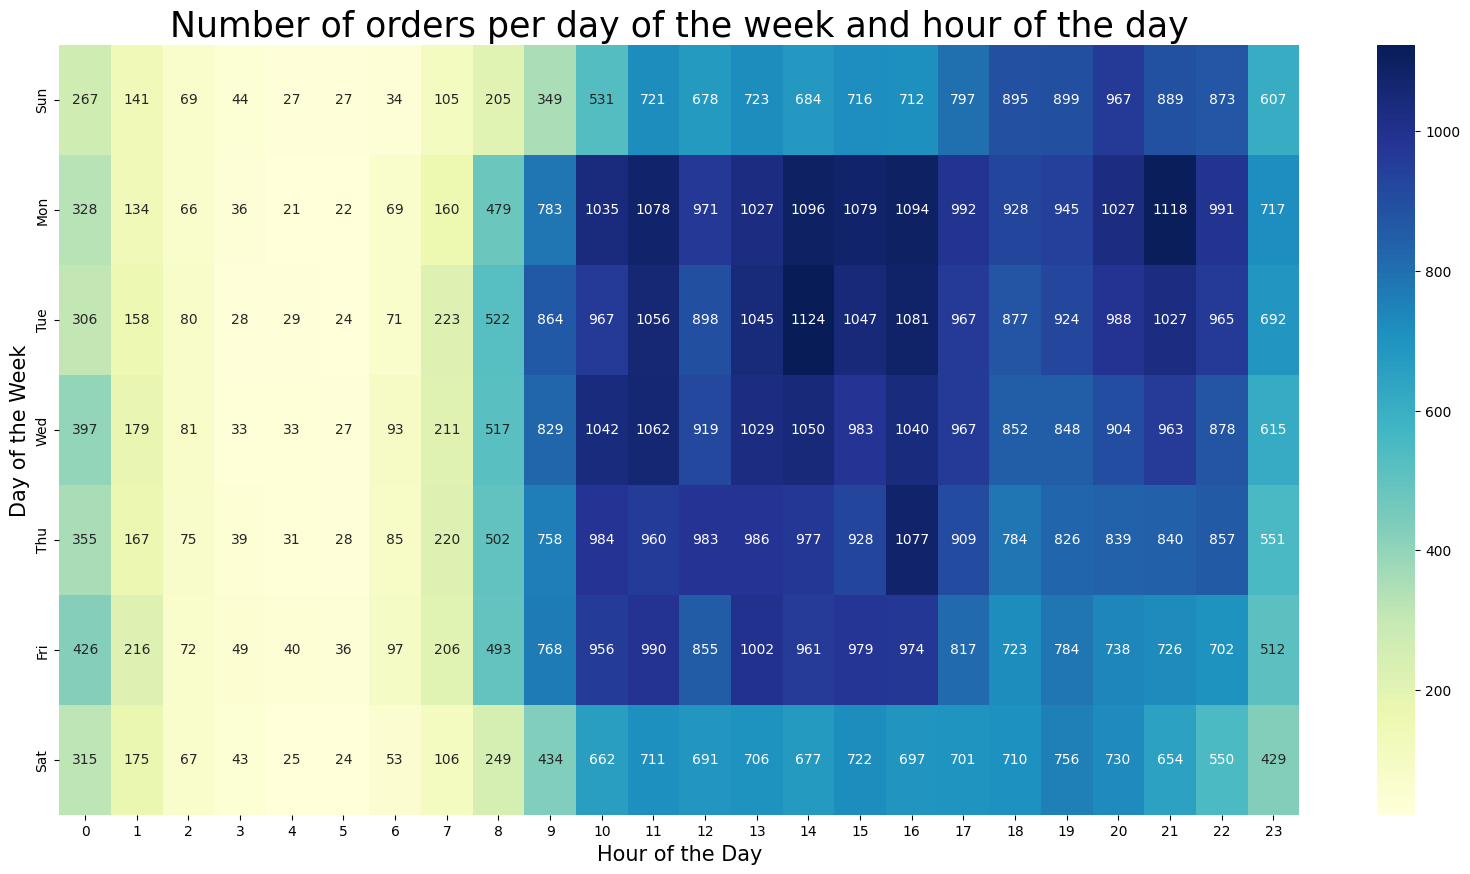

In [8]:
plt.figure(figsize=(20, 10)) 
sns.heatmap(df, annot=True, fmt="d", cmap="YlGnBu") 
plt.title('Number of orders per day of the week and hour of the day',fontdict={'fontsize':25}) 
plt.xlabel('Hour of the Day',fontdict={'fontsize':15}) 
plt.ylabel('Day of the Week',fontdict={'fontsize':15}) 
plt.show()

This heatmap illustrates the number of orders by day of the week and hour of the day, revealing several notable patterns. The highest order volumes occur between 10 AM and 4 PM across all days, with Tuesday and Monday standing out as the busiest days, particularly between 1 PM and 4 PM. In contrast, the lowest order volumes are observed during the early morning hours (12 AM to 6 AM) on all days, with Sunday having the least activity overall, especially in the early morning. A general trend emerges where orders increase steadily from morning to noon before gradually declining in the evening. Weekdays (Monday to Friday) consistently show higher order volumes compared to weekends (Saturday and Sunday). Notably, the peak hour of the week is 1 PM to 2 PM on Tuesday, with the number of orders exceeding 1,100. The heatmap’s color scheme, ranging from light yellow for fewer orders to deep blue for more orders, effectively highlights areas of high and low order density, making it easy to identify key trends at a glance.

We have analyzed the distribution of orders over time and now want to determine which cities have the highest number of orders. To visualize this, we will use a bar plot to display the top 10 countries with the most orders.

C:\Users\minhn\AppData\Local\Temp\ipykernel_25768\2237196247.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


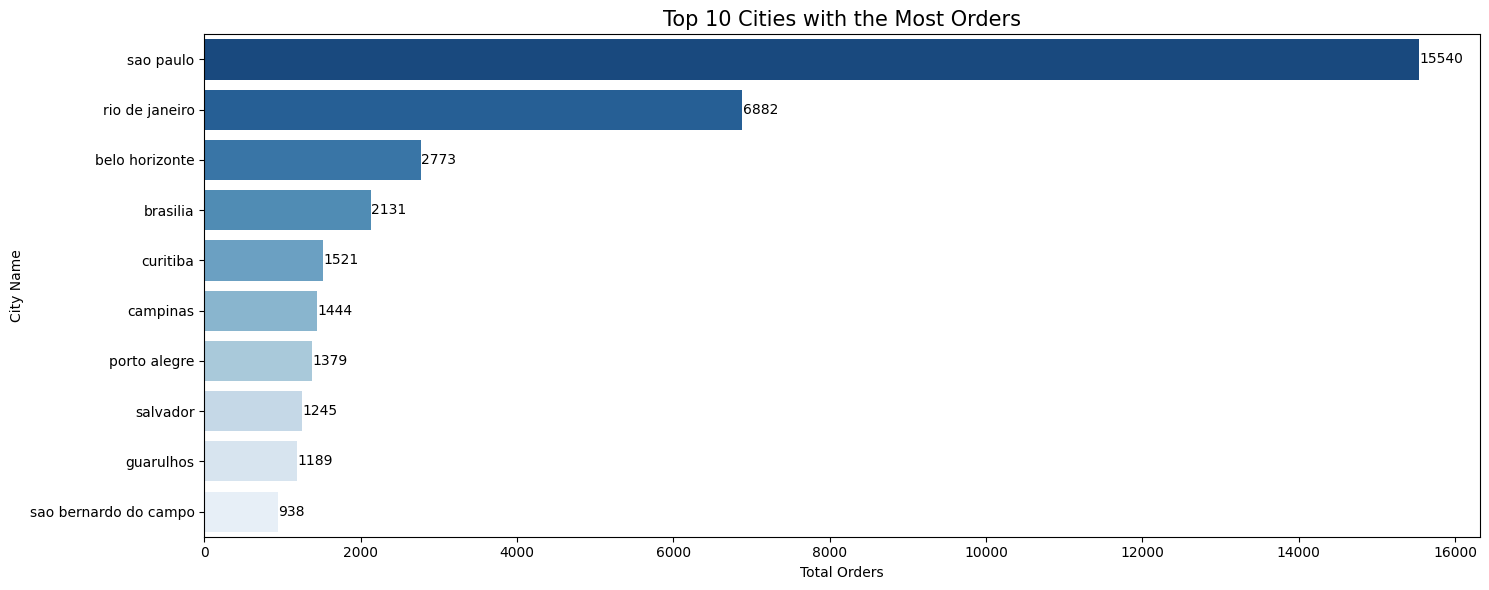

In [9]:
city_10_or = """
SELECT c.customer_city  as "City name", 
	count(o.order_id) as "Total order" 
from customers c 
left join orders o on c.customer_id = o.customer_id 
group by c.customer_city 
order by "Total order" DESC
LIMIT 10
"""
df_ci_or = pd.read_sql_query(city_10_or, db_connection)
plt.figure(figsize=(15, 6))
sns.barplot(
    data=df_ci_or,
    x="Total order",  # Horizontal axis
    y="City name",    # Vertical axis
    palette="Blues_r" # Color palette
)

# Add annotations to each bar
for index, row in df_ci_or.iterrows():
    plt.text(row["Total order"] + 5, index, str(row["Total order"]), color="black", va="center")

# Add labels and title
plt.xlabel("Total Orders")
plt.ylabel("City Name")
plt.title("Top 10 Cities with the Most Orders", fontdict={'fontsize':15})

# Display the plot
plt.tight_layout()
plt.show()


The bar chart highlights the top 10 cities with the highest number of orders, showcasing São Paulo as the dominant leader with 15,540 orders, which is more than double the total of the second-ranking city, Rio de Janeiro (6,882 orders). This significant lead underscores São Paulo's importance as a key market. Beyond the top two cities, there is a steep drop in order volumes, with Belo Horizonte ranking third at only 2,773 orders, less than half of Rio de Janeiro's total. Cities like Brasília, Curitiba, and Porto Alegre also contribute moderately, reflecting a broader regional distribution. Notably, while cities like Guarulhos and São Bernardo do Campo make it to the top 10, their order numbers are relatively low compared to the leading cities. This distribution suggests that businesses should prioritize São Paulo and Rio de Janeiro for their strategies while exploring opportunities in other emerging cities for potential growth.

## II. Order Price

What are the mean values for product price and order price? Does Olist have a significant number of high-value orders? Does product price significantly influence the number of orders for each product?

Initially, we will determine the minimum, mean, and maximum product prices, as well as the total order price.

In [10]:
product_stat = """
select 
min(oi.price) as "Min product price",
ROUND(AVG(oi.price),2) as "Average product price",
max(oi.price) as "Max product price"
from order_items oi 
join products p on p.product_id = oi.product_id;
"""

order_stat = """
SELECT
    MIN(order_price) AS "Min order price",
    ROUND(AVG(order_price), 2) AS "Average order price",
    MAX(order_price) AS "Max order price"
FROM (
    SELECT
        orders.order_id,
        SUM(order_items.price + order_items.freight_value) AS order_price
    FROM orders
        JOIN order_items USING (order_id)
    GROUP BY orders.order_id
)
"""
print("\033[1mProduct price statistic\033[0m \n",pd.read_sql_query(product_stat, db_connection),"\n\n")
print("\033[1mTotal order price statistic\033[0m \n",pd.read_sql_query(order_stat, db_connection))

Product price statistic 
    Min product price  Average product price  Max product price
0               0.85                 120.65             6735.0 


Total order price statistic 
    Min order price  Average order price  Max order price
0             9.59               160.58         13664.08


We observe that the average order price and average product price are significantly lower than the maximum order and product prices. This suggests that the price distribution is right-skewed, indicating that most customers tend to purchase numerous inexpensive products and are generally cautious about spending excessively on a single order.

We will use histogram to explore the distribution of product price as well as order price.

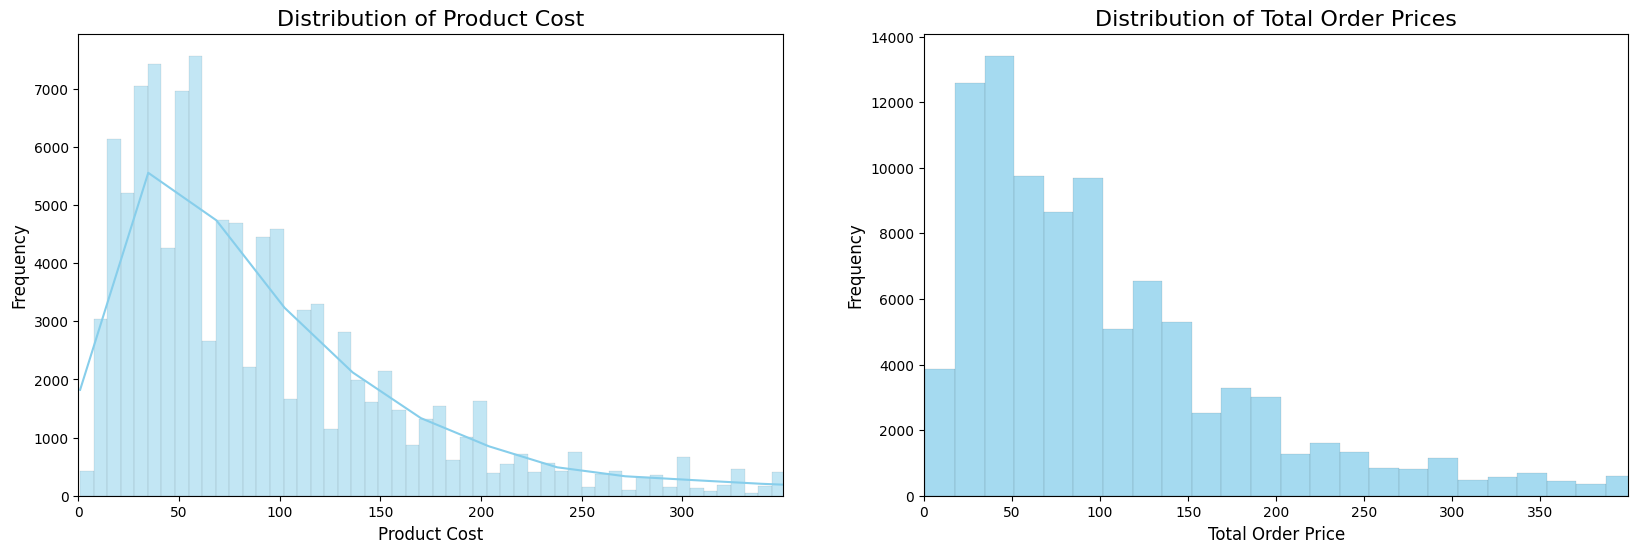

In [11]:
query_order_prices = """
SELECT o.order_id, SUM(oi.price) AS total_order_price
FROM order_items oi
JOIN orders o ON oi.order_id = o.order_id
GROUP BY o.order_id;
"""
query_product = """
SELECT o.order_id, oi.price, pc.product_category_name_english
FROM order_items oi
JOIN products p ON oi.product_id = p.product_id
JOIN orders o ON oi.order_id = o.order_id
join product_category_name_translation pc on p.product_category_name = pc.product_category_name;
"""

# Plot the distribution of total order prices
data_order_prices = pd.read_sql_query(query_order_prices, db_connection)
plt.figure(figsize=(20, 6))
plt.subplot(1, 2, 2)
sns.histplot(data_order_prices['total_order_price'], bins=800, kde=False, color='skyblue')
plt.title("Distribution of Total Order Prices", fontsize=16)
plt.xlabel("Total Order Price", fontsize=12)
plt.ylabel("Frequency", fontsize=12)
plt.xlim(0, data_order_prices['total_order_price'].quantile(0.95))  # Focus on the 95th percentile for clarity

# Price Distribution
data = pd.read_sql_query(query_product, db_connection)
plt.subplot(1, 2, 1)
sns.histplot(data['price'], bins=1000, kde=True, color='skyblue')
plt.title("Distribution of Product Cost", fontsize=16)
plt.xlabel("Product Cost", fontsize=12)
plt.ylabel("Frequency", fontsize=12)
plt.xlim(0, data['price'].quantile(0.95))  # Focus on the 95th percentile for clarity
plt.show()


As we expect, the histogram for product costs shows a clear right-skewed distribution, with most products priced below $100, indicating a focus on affordability. A small number of high-cost outliers suggest the presence of specialized or premium products. Similarly, the distribution of total order prices also exhibits a right-skewed pattern, with the majority of orders concentrated in the lower range, reflecting that customers tend to make smaller orders. The kernel density estimate (KDE) curve in the total order price plot further emphasizes this trend. By focusing on the 95th percentile of data, the graphs effectively highlight typical purchasing behavior while excluding extreme outliers. The similarity in skewness between the two distributions suggests a relationship where customers purchasing low-cost products also tend to have lower total order values. Exploring the characteristics of customers contributing to the high-value tails in both distributions could provide valuable insights for strategies to increase the average order value.

## III. Product Category

What is the most profitable product? Which products generate the highest revenue, and which have the greatest number of orders? To answer these questions, we will create a table listing the top 10 products. This table will include three key features: product name, total revenue, and the number of orders, and it will be sorted in descending order based on total revenue.

C:\Users\minhn\AppData\Local\Temp\ipykernel_25768\1499329504.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  bar_plot = sns.barplot(


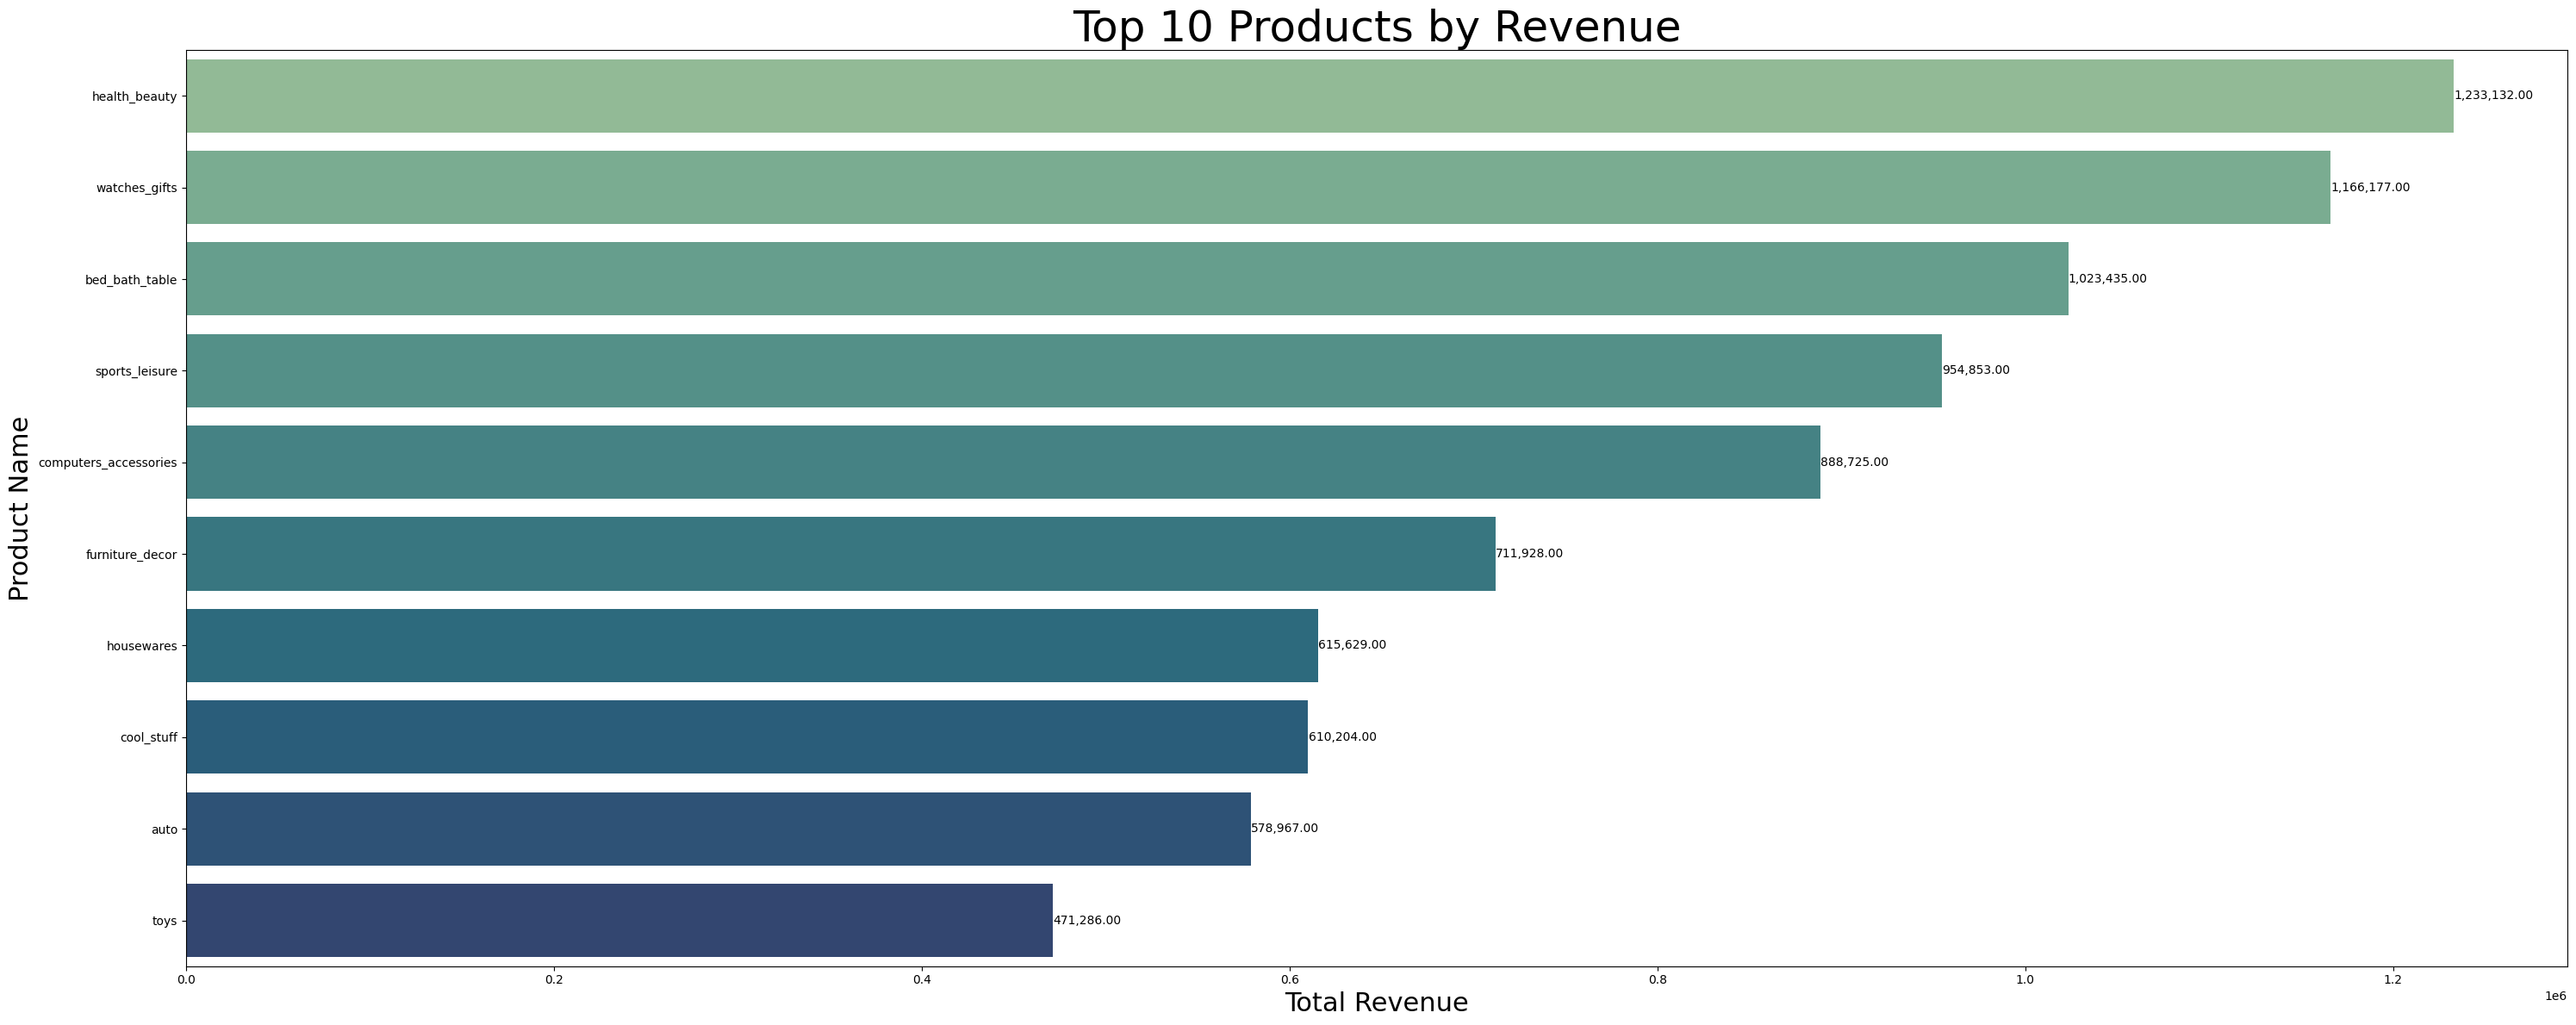

            Product name  Total order price  Number of product
0          health_beauty          1233132.0               9465
1          watches_gifts          1166177.0               5859
2         bed_bath_table          1023435.0              10953
3         sports_leisure           954853.0               8431
4  computers_accessories           888725.0               7644
5        furniture_decor           711928.0               8160
6             housewares           615629.0               6795
7             cool_stuff           610204.0               3718
8                   auto           578967.0               4140
9                   toys           471286.0               4030


In [12]:
prod_revenue = """
select pcnt.product_category_name_english as "Product name",
round(sum(oi.price)) as "Total order price",
count(oi.product_id) as "Number of product"
from order_items oi 
join products p on p.product_id =oi.product_id 
join product_category_name_translation pcnt on pcnt.product_category_name = p.product_category_name 
join orders o on o.order_id =oi.order_id 
WHERE o.order_status ='delivered'
group by "Product name"
order by "Total order price" DESC
limit 10;
"""

df_prod_revenue = pd.read_sql_query(prod_revenue, db_connection)
plt.figure(figsize=(30, 12))
bar_plot = sns.barplot(
    data=df_prod_revenue,
    x="Total order price",  # Horizontal axis
    y="Product name",    # Vertical axis
    palette="crest" # Color palette
)
# Add annotations
for i, bar in enumerate(bar_plot.patches):
    plt.text(
        bar.get_width() + 100,  # Adjust text position slightly outside the bar
        bar.get_y() + bar.get_height() / 2,  # Center text vertically on the bar
        f"{bar.get_width():,.2f}",  # Format the text (e.g., comma-separated, 2 decimals)
        ha="left",  # Align text to the left
        va="center",  # Align text to the center
        fontsize=10   # Text size
    )

plt.title("Top 10 Products by Revenue", fontsize=36)
plt.xlabel("Total Revenue", fontsize=22)
plt.ylabel("Product Name", fontsize=22)
plt.tight_layout()
plt.show()
print(df_prod_revenue)

The "health_beauty" category emerges as the most profitable, generating approximately 1.23 million in revenue, followed closely by "watches_gifts" at around 1.17 million. A noticeable decline in revenue is observed as we move down the list, with "toys" being the least profitable among the top 10, contributing approximately 471k. The top three categories—"health_beauty," "watches_gifts," and "bed_bath_table"—stand out as dominant revenue contributors, indicating their critical role in overall profitability. The annotations on the plot provide precise revenue values for each product, facilitating easy comparison and identification of key contributors. These insights suggest prioritizing marketing and inventory strategies for the highest-performing categories while exploring opportunities to boost revenue for the lower-ranked products.

## IV. Order Review

Do all orders have high review scores? How many orders received low review scores? What is the main reason for the low scores? To begin, we will use a bar plot to illustrate the distribution of review scores.

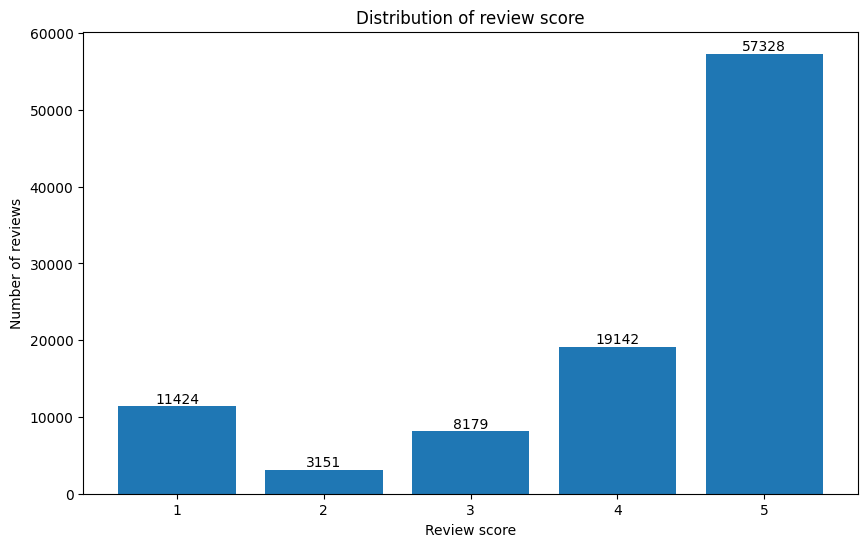

In [13]:
rev_dist = """
SELECT or2.review_score,
COUNT(or2.review_score) as "Number of score" 
from order_reviews or2 
group by or2.review_score
""" 
df_rev_dist = pd.read_sql_query(rev_dist, db_connection)
plt.figure(figsize=(10,6))
bars = plt.bar(df_rev_dist['review_score'], df_rev_dist['Number of score'])
for bar in bars:
    height = bar.get_height()
    plt.text(
        bar.get_x() + bar.get_width() / 2,  # x-coordinate
        height + 5,  # y-coordinate (slightly above the bar)
        f'{int(height)}',  # Annotation text
        ha='center',  # Horizontal alignment
        va='bottom',  # Vertical alignment
        fontsize=10,  # Font size
        color='black'  # Text color
    )
plt.xlabel('Review score')
plt.ylabel('Number of reviews')
plt.title('Distribution of review score')
plt.show()

The data reveals that the majority of reviews are highly positive, as a score of 5 accounts for the largest number of reviews, totaling 57,328. This is significantly higher than any other score. Scores of 4 also have a considerable amount of reviews, at 19,142, indicating that most customers were satisfied. On the other hand, lower scores, such as 1, 2, and 3, have far fewer reviews, with 11,424, 3,151, and 8,179, respectively. The low number of reviews for scores 1 and 2 suggests that dissatisfaction is relatively uncommon. Overall, the chart reflects a strong trend toward positive customer experiences, with high ratings dominating the review distribution.

Now, we will identify the main reasons behind low review scores. Considering scores of 1, 2, and 3 as low ratings, we will create a word cloud from the comment messages to explore the underlying causes.

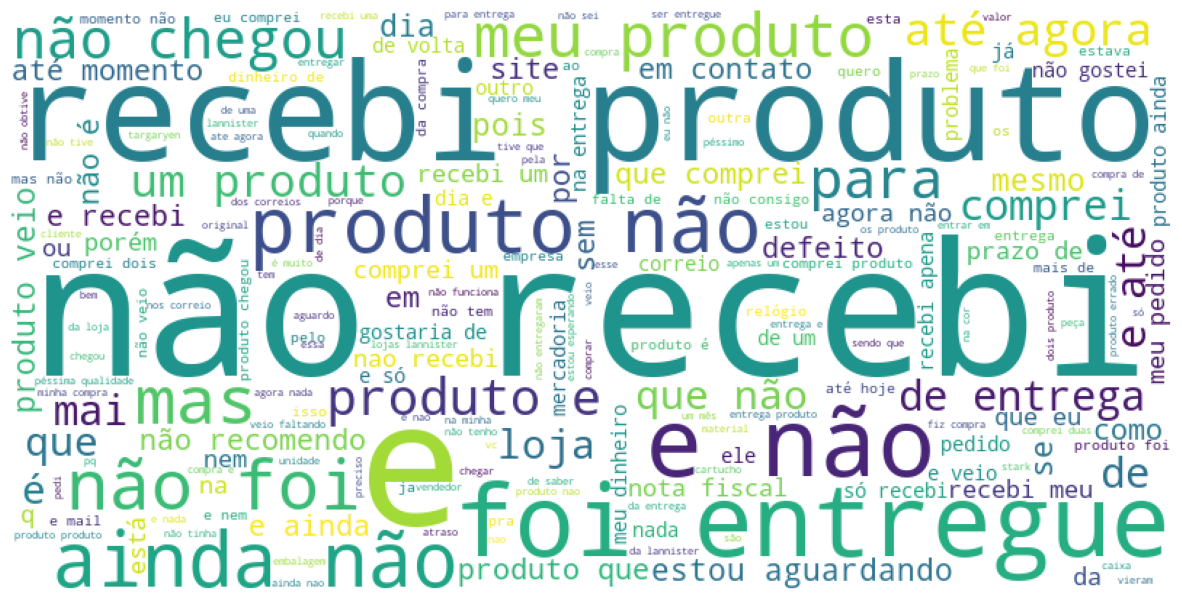

In [14]:
# Fetch and clean negative review comments
query = """
SELECT r.review_comment_message AS review_text
FROM order_reviews r
WHERE r.review_score IN (1, 2) AND r.review_comment_message IS NOT NULL;
"""
negative_reviews = pd.read_sql_query(query, db_connection)
stop_words = set(stopwords.words('english'))
cleaned_text = ' '.join(
    word.lower() for word in re.findall(r'\b\w+\b', ' '.join(negative_reviews['review_text']))
    if word.lower() not in stop_words
)

# Generate and display word cloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(cleaned_text)
plt.figure(figsize=(15, 8))
plt.imshow(wordcloud)
plt.axis("off")
plt.show()


The most prominent words, such as "não recebi" (I didn’t receive), "produto" (product), and "entregue" (delivered), indicate that issues related to undelivered or missing products are the primary sources of dissatisfaction. Other frequent terms like "não chegou" (didn’t arrive), "defeito" (defective), and "atraso" (delay) further highlight problems with shipping, product quality, and timeliness. Overall, the word cloud suggests that logistical and product-related issues significantly contribute to low customer satisfaction scores

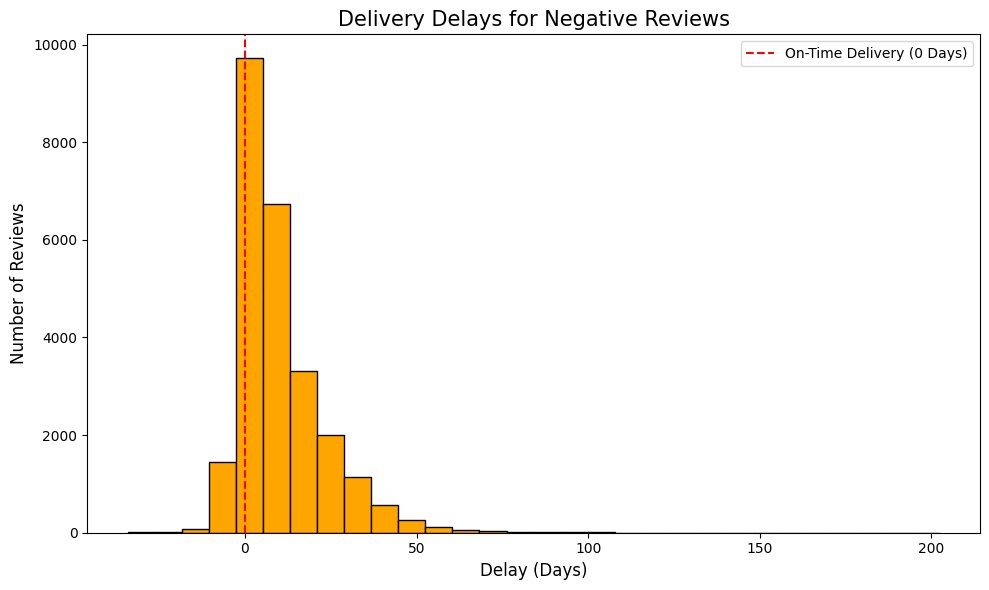

In [15]:
# Query to fetch delay and review score for negative reviews
query = """
SELECT 
    o.order_id,
    r.review_score,
    julianday(o.order_delivered_customer_date) - julianday(oi.shipping_limit_date) AS delay_days
FROM orders o
JOIN order_reviews r ON o.order_id = r.order_id
JOIN order_items oi ON o.order_id = oi.order_id
WHERE o.order_delivered_customer_date IS NOT NULL 
  AND oi.shipping_limit_date IS NOT NULL
  AND r.review_score IN (1, 2, 3);
"""
negative_review_data = pd.read_sql_query(query, db_connection)

# Drop null or invalid delay values
negative_review_data = negative_review_data.dropna(subset=['delay_days'])

# Plot distribution of delay for poor reviews
plt.figure(figsize=(10, 6))
plt.hist(negative_review_data['delay_days'], bins=30, color='orange', edgecolor='black')
plt.title('Delivery Delays for Negative Reviews', fontsize=15)
plt.xlabel('Delay (Days)', fontsize=12)
plt.ylabel('Number of Reviews', fontsize=12)
plt.axvline(0, color='red', linestyle='--', label='On-Time Delivery (0 Days)')
plt.legend()
plt.tight_layout()
plt.show()


From the histogram above, we observed that delays are a significant issue, with most orders being delivered late. Olist should focus on improving this aspect to enhance customer satisfaction.

## V. Order delivery

In the orders table, we observe five key features: approved_time, purchase_timestamp, delivered_carrier_date, delivered_customer_date, and estimated_delivery_date. To better understand this data, we will visualize it using a horizontal bar plot for the 10 cities with the highest number of orders.

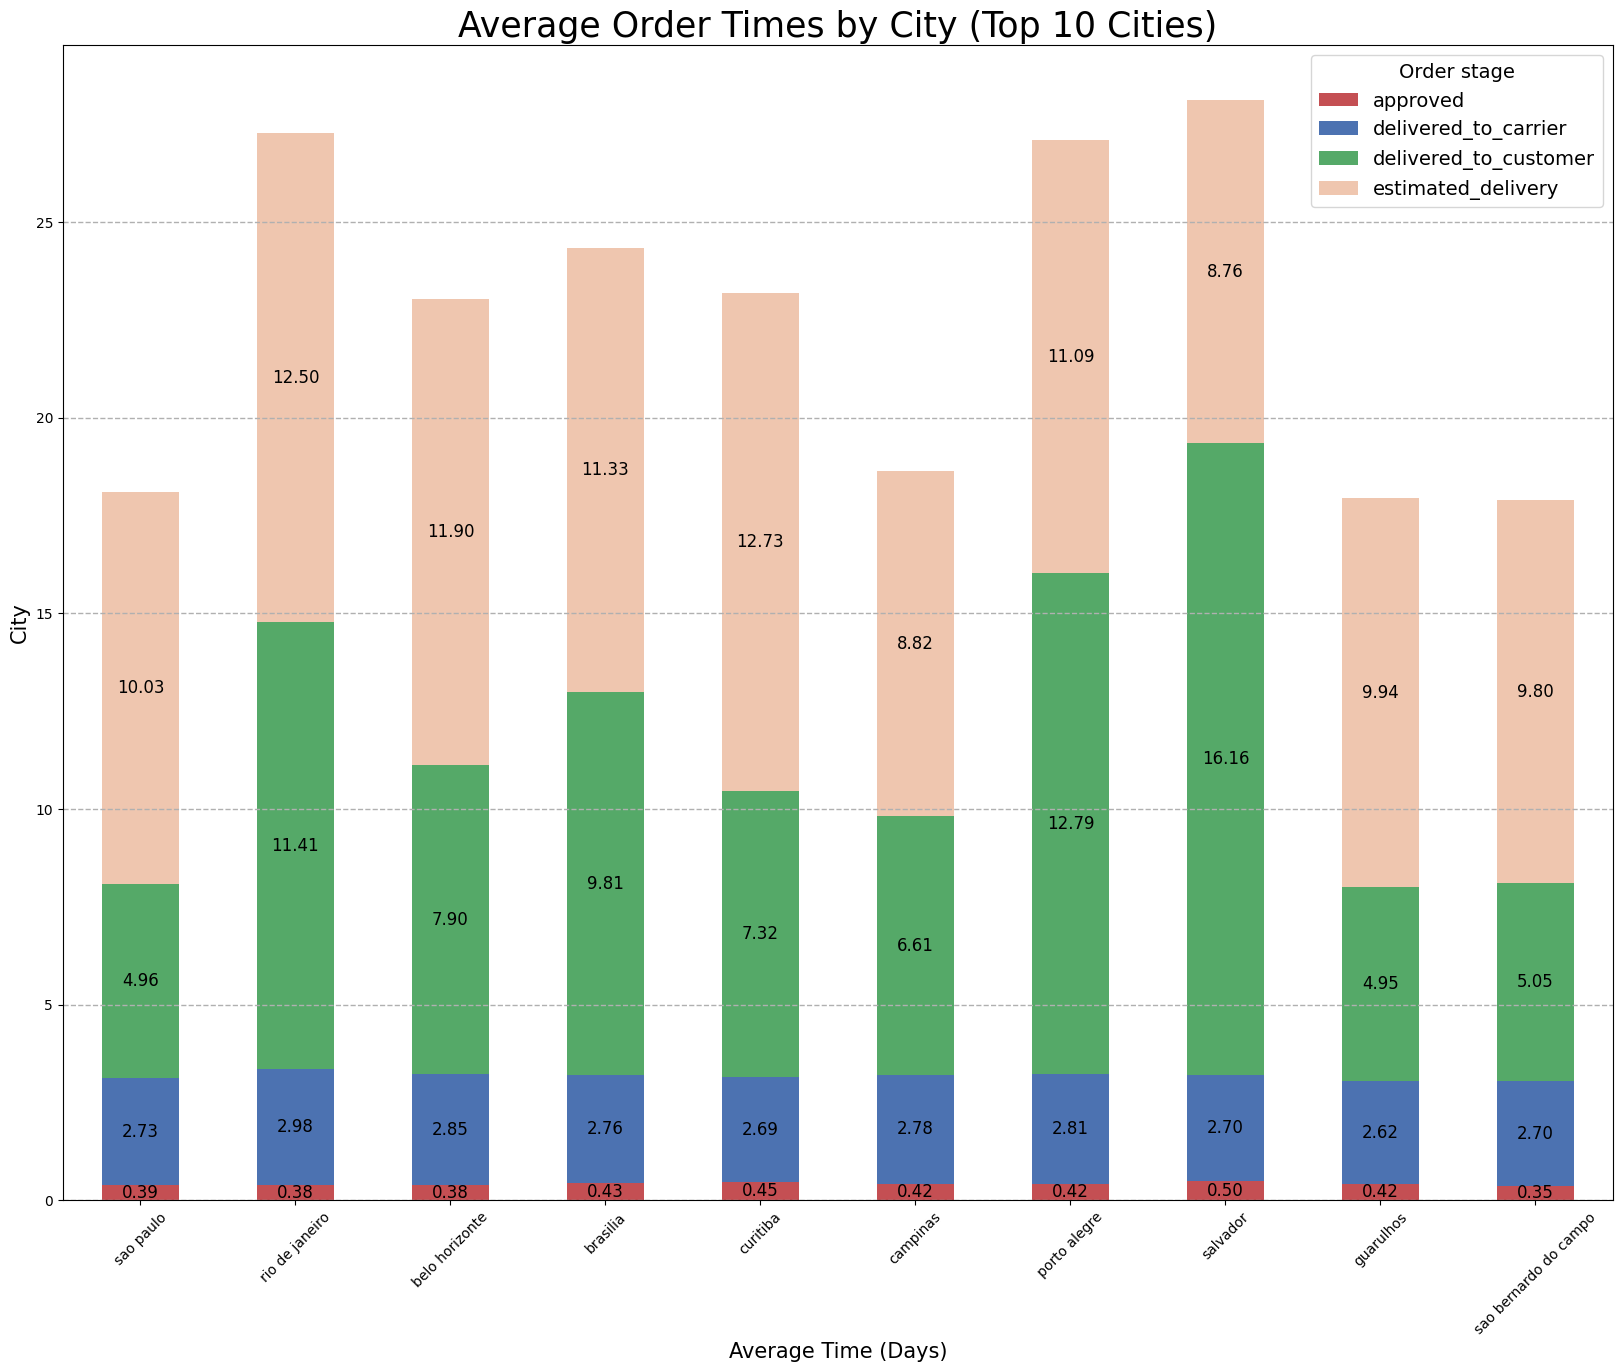

In [16]:
order_time = """
SELECT c.customer_city  as "City", 
	count(o.order_id) as "Total order",
	AVG(JULIANDAY(order_approved_at) - JULIANDAY(order_purchase_timestamp)) AS approved,
    AVG(JULIANDAY(order_delivered_carrier_date) - JULIANDAY(order_approved_at)) AS delivered_to_carrier,
    AVG(JULIANDAY(order_delivered_customer_date) - JULIANDAY(order_delivered_carrier_date)) AS delivered_to_customer,
    AVG(JULIANDAY(order_estimated_delivery_date) - JULIANDAY(order_delivered_customer_date)) AS estimated_delivery 
from customers c 
left join orders o on c.customer_id = o.customer_id 
group by c.customer_city 
order by "Total order" DESC
LIMIT 10
"""
df_order_time = pd.read_sql_query(order_time, db_connection)
df_order_time = df_order_time.drop(columns=["Total order"])
fig, ax = plt.subplots(figsize=(20, 15))
df_order_time.plot(x="City",kind='bar', stacked=True, color=['#c44f53', '#4c72b1', '#55a968', '#dd845275'],ax=ax)
plt.grid(linestyle='--', linewidth=1,axis='y')
max_bar_length = int(df.sum(axis=1).max())
plt.title('Average Order Times by City (Top 10 Cities)',fontdict={'fontsize':25})
plt.xlabel('Average Time (Days)',fontdict={'fontsize':15})
plt.ylabel('City',fontdict={'fontsize':15})
ax.tick_params(axis='x', rotation=45) 
plt.legend(title='Order stage', title_fontsize=14, fontsize=14)
for container in ax.containers:
    ax.bar_label(container, fmt='%.2f', label_type='center', fontsize=12)
plt.show()

The most noticeable pattern is that the "estimated delivery" stage consistently occupies the largest portion of the total time across all cities, with Salvador exhibiting the highest value (16.16 days). The "delivered to customer" stage is also substantial, varying from 6.61 days in Campinas to 12.79 days in Porto Alegre. In contrast, the "approved" stage contributes minimally, typically less than 0.5 days in all cities. Similarly, the "delivered to carrier" stage averages around 2.5–3 days, remaining relatively consistent. This distribution highlights that delays in the "estimated delivery" and "delivered to customer" stages are the primary contributors to the total order times, suggesting opportunities for improvement in these phases to enhance overall efficiency and customer satisfaction.

We add an average delivery line to compare the cities and identify which ones need to improve their shipping services.

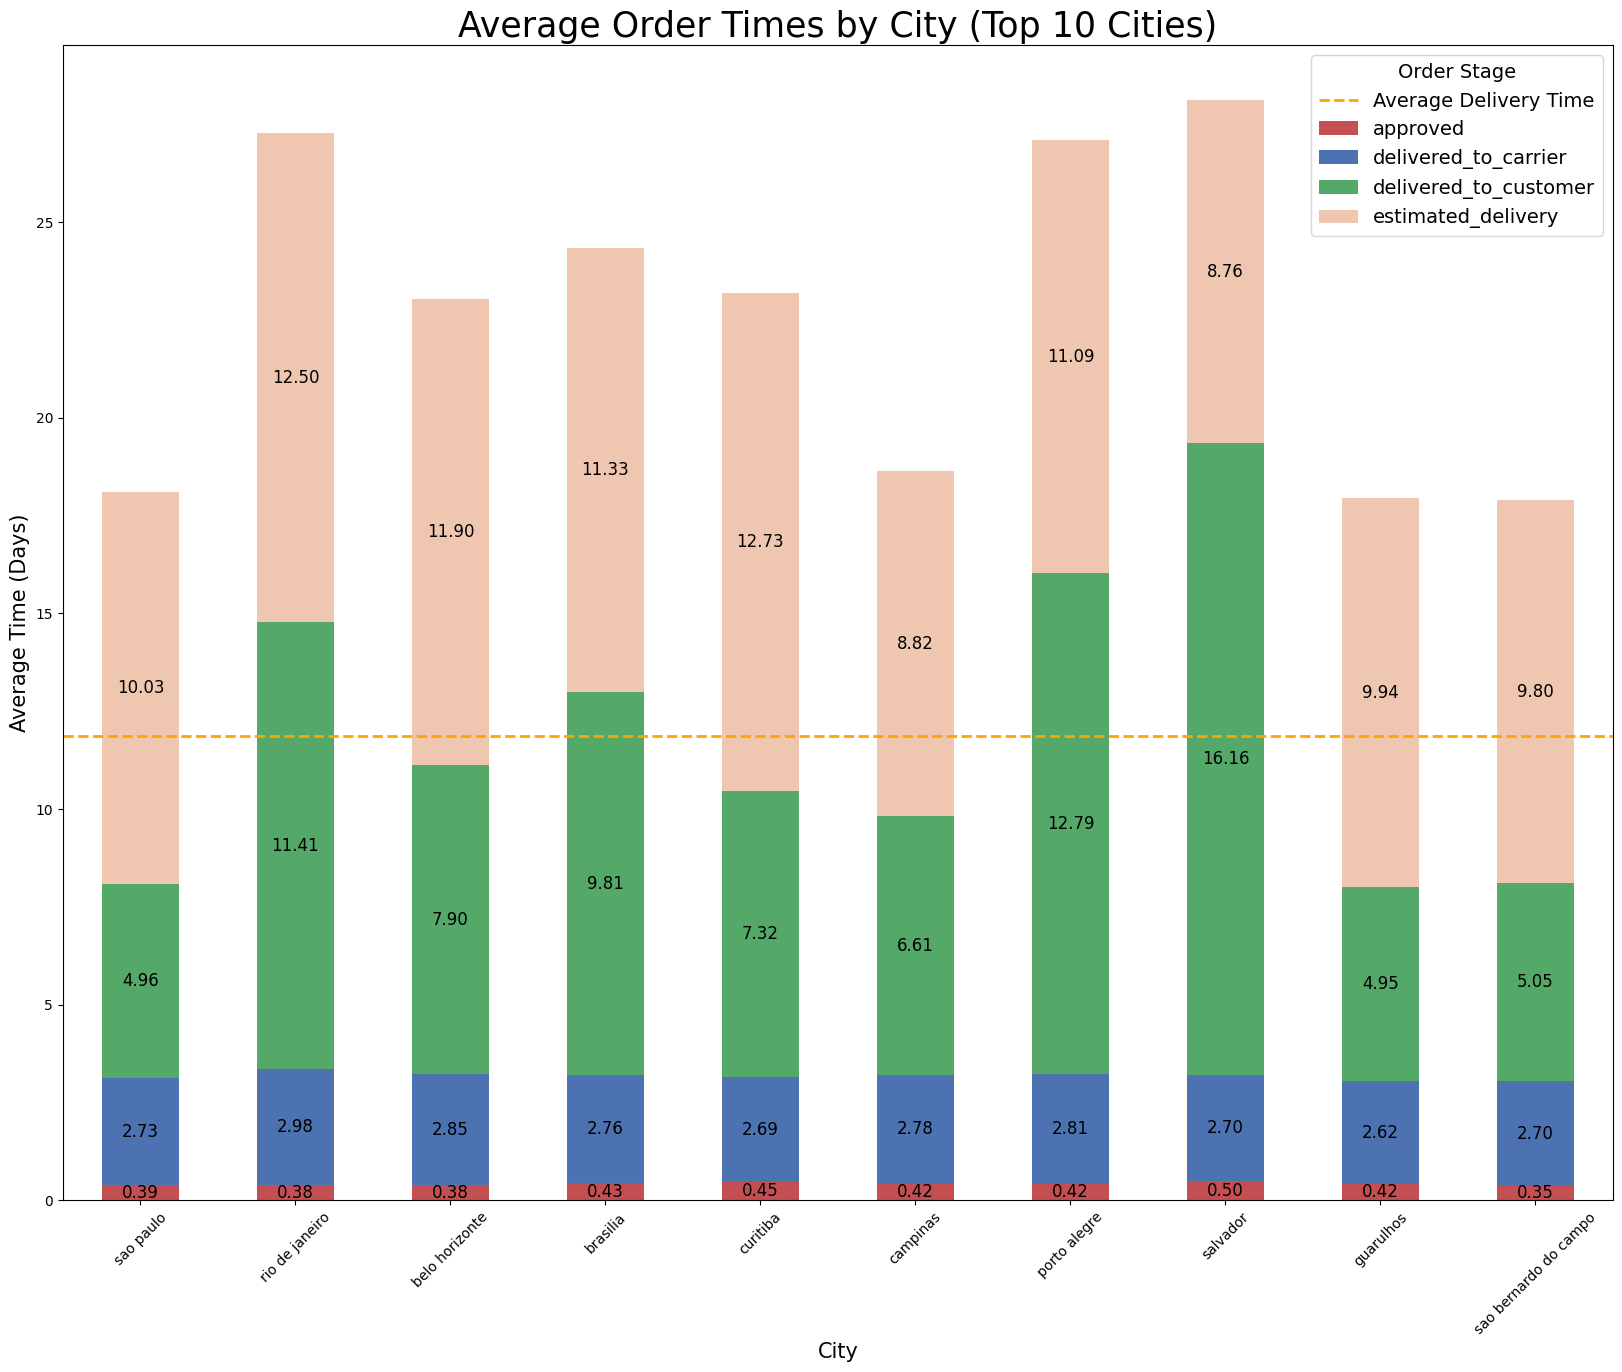

In [17]:
# Calculate overall average delivery time
overall_avg_delivery = df_order_time[['approved', 'delivered_to_carrier', 'delivered_to_customer']].mean().sum()

fig, ax = plt.subplots(figsize=(20, 15))
df_order_time.plot(x="City", kind='bar', stacked=True, color=['#c44f53', '#4c72b1', '#55a968', '#dd845275'], ax=ax)

# Add the average delivery line
ax.axhline(overall_avg_delivery, color='orange', linestyle='--', linewidth=2, label=f'Average Delivery Time')
plt.title('Average Order Times by City (Top 10 Cities)', fontdict={'fontsize': 25})
plt.xlabel('City', fontdict={'fontsize': 15})
plt.ylabel('Average Time (Days)', fontdict={'fontsize': 15})
ax.tick_params(axis='x', rotation=45) 
plt.legend(title='Order Stage', title_fontsize=14, fontsize=14)
for container in ax.containers:
    ax.bar_label(container, fmt='%.2f', label_type='center', fontsize=12)
plt.show()

We can conclude that four cities—Rio de Janeiro, Brasília, Porto Alegre, and Salvador—have total delivery times higher than the average, while others are below the average. The primary reason for the delay is the extended delivery time to customers, which averages around 8 days. To enhance customer satisfaction, Olist should focus on improving its logistics system in these cities, as delays are a key factor contributing to customer dissatisfaction and frustration.

## VI. Customer Segmentation

SQL is a powerful and versatile tool that can be used effectively for customer segmentation, allowing businesses to better understand and serve their customer base. One of the most popular and straightforward segmentation techniques is RFM segmentation, which categorizes customers based on three critical metrics:

***Recency:*** This measures how recently a customer made their last purchase. Customers who have shopped more recently are typically more engaged and likely to return compared to those whose last purchase was further in the past.

***Frequency:*** This metric assesses how often a customer makes purchases over a given period. Frequent buyers are usually more loyal and can be prioritized for reward programs or exclusive offers.

***Monetary Value:*** This evaluates how much a customer spends on average. High-spending customers contribute more to the business’s revenue and may warrant special attention or premium services.

The RFM method involves calculating these metrics for each customer and assigning them scores, typically on a scale of 1 to 5, where higher scores indicate better performance in that metric. Customers are then grouped into specific categories or "buckets" based on their combined RFM scores.

For instance, a customer with high recency, frequency, and monetary scores might be classified as a "Champion," representing a highly engaged and valuable customer. On the other hand, a customer with low scores might fall into the "Lost" category, suggesting they may need re-engagement strategies to bring them back.

This segmentation approach is incredibly useful for businesses aiming to improve customer retention, design targeted marketing campaigns, or optimize customer service. By understanding the unique behaviors and preferences of each customer group, businesses can create tailored strategies to meet specific needs, enhance satisfaction, and ultimately drive growth.

Using SQL for RFM segmentation is especially advantageous due to its ability to handle large datasets efficiently and perform complex calculations with ease. Once the data is segmented, businesses can leverage insights to make informed decisions and build deeper relationships with their customers.

In [18]:
rfm_buckets = """
-- 1. Calculate RFM scores
WITH RecencyScore AS (
    SELECT customer_unique_id,
           MAX(order_purchase_timestamp) AS last_purchase,
           NTILE(5) OVER (ORDER BY MAX(order_purchase_timestamp) DESC) AS recency
    FROM orders
        JOIN customers USING (customer_id)
    WHERE order_status = 'delivered'
    GROUP BY customer_unique_id
),
FrequencyScore AS (
    SELECT customer_unique_id,
           COUNT(order_id) AS total_orders,
           NTILE(5) OVER (ORDER BY COUNT(order_id) DESC) AS frequency
    FROM orders
        JOIN customers USING (customer_id)
    WHERE order_status = 'delivered'
    GROUP BY customer_unique_id
),
MonetaryScore AS (
    SELECT customer_unique_id,
           SUM(price) AS total_spent,
           NTILE(5) OVER (ORDER BY SUM(price) DESC) AS monetary
    FROM orders
        JOIN order_items USING (order_id)
        JOIN customers USING (customer_id)
    WHERE order_status = 'delivered'
    GROUP BY customer_unique_id
),

-- 2. Assign each customer to a group
RFM AS (
    SELECT last_purchase, total_orders, total_spent,
        CASE
            WHEN recency = 1 AND frequency + monetary IN (1, 2, 3, 4) THEN "Champions"
            WHEN recency IN (4, 5) AND frequency + monetary IN (1, 2) THEN "Can't Lose Them"
            WHEN recency IN (4, 5) AND frequency + monetary IN (3, 4, 5, 6) THEN "Hibernating"
            WHEN recency IN (4, 5) AND frequency + monetary IN (7, 8, 9, 10) THEN "Lost"
            WHEN recency IN (2, 3) AND frequency + monetary IN (1, 2, 3, 4) THEN "Loyal Customers"
            WHEN recency = 3 AND frequency + monetary IN (5, 6) THEN "Needs Attention"
            WHEN recency = 1 AND frequency + monetary IN (7, 8) THEN "Recent Users"
            WHEN recency = 1 AND frequency + monetary IN (5, 6) OR
                recency = 2 AND frequency + monetary IN (5, 6, 7, 8) THEN "Potentital Loyalists"
            WHEN recency = 1 AND frequency + monetary IN (9, 10) THEN "Price Sensitive"
            WHEN recency = 2 AND frequency + monetary IN (9, 10) THEN "Promising"
            WHEN recency = 3 AND frequency + monetary IN (7, 8, 9, 10) THEN "About to Sleep"
        END AS RFM_Bucket
    FROM RecencyScore
        JOIN FrequencyScore USING (customer_unique_id)
        JOIN MonetaryScore USING (customer_unique_id)
)

-- 3. Calculate group statistics for plotting
SELECT RFM_Bucket, 
       AVG(JULIANDAY('now') - JULIANDAY(last_purchase)) AS avg_days_since_purchase, 
       AVG(total_spent / total_orders) AS avg_sales_per_customer,
       COUNT(*) AS customer_count
FROM RFM
GROUP BY RFM_Bucket
"""
df_buckets = pd.read_sql(rfm_buckets, db_connection)
df_buckets

,RFM_Bucket,avg_days_since_purchase,avg_sales_per_customer,customer_count
0,About to Sleep,2546.850301,57.684959,7584
1,Can't Lose Them,2720.153610,350.886817,1723
2,Champions,2373.880867,250.856821,4607
3,Hibernating,2721.163287,182.845816,20288
4,Lost,2723.692065,57.393210,15331
5,Loyal Customers,2504.346330,237.881257,9315
6,Needs Attention,2547.907381,145.904925,6510
7,Potentital Loyalists,2431.041499,130.374773,18114
8,Price Sensitive,2372.505462,34.909351,2220
9,Promising,2463.995134,35.085359,2245


Let visualize this table by using a scatter plot.

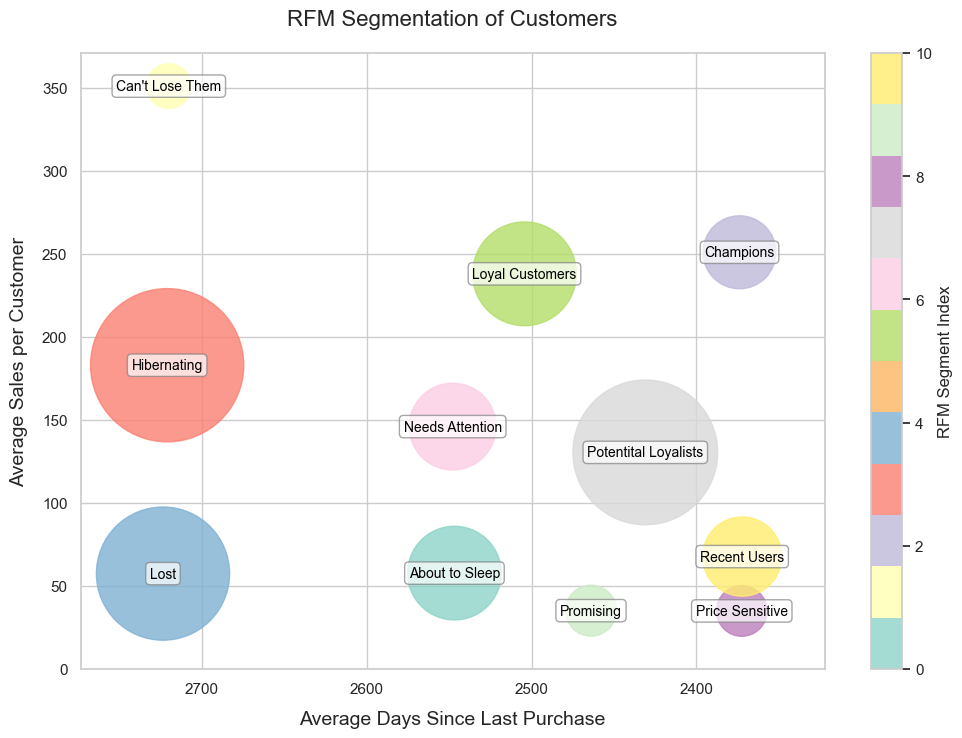

In [19]:
# Set up the figure size and styling
plt.figure(figsize=(12, 8))
sns.set(style="whitegrid")

# Scatter plot with improved readability
scatter = plt.scatter(
    df_buckets['avg_days_since_purchase'], 
    df_buckets['avg_sales_per_customer'],
    s=df_buckets['customer_count'] * 0.6,  # Adjusted scaling factor for better visualization
    c=range(len(df_buckets)),  # Dynamic color palette
    cmap='Set3',       # Using a colormap for consistency
    alpha=0.8          # Added transparency for better overlap visibility
)

# Add labels and title
plt.xlabel('Average Days Since Last Purchase', fontsize=14, labelpad=10)
plt.ylabel('Average Sales per Customer', fontsize=14, labelpad=10)
plt.title('RFM Segmentation of Customers', fontsize=16, pad=20)

# Add annotations for each data point
for i, text in enumerate(df_buckets['RFM_Bucket']):
    plt.annotate(
        text, 
        (df_buckets['avg_days_since_purchase'][i], df_buckets['avg_sales_per_customer'][i]),
        ha='center', 
        va='center',
        fontsize=10, 
        color='black',
        bbox=dict(boxstyle='round,pad=0.3', edgecolor='gray', facecolor='white', alpha=0.7)
    )

# Adjust axis limits and inversion
plt.gca().invert_xaxis()
plt.xlim(df_buckets['avg_days_since_purchase'].max() + 50, df_buckets['avg_days_since_purchase'].min() - 50)
plt.ylim(0, df_buckets['avg_sales_per_customer'].max() + 20)

# Add a color bar for context
plt.colorbar(scatter, label='RFM Segment Index')

# Show the plot
plt.show()

High-value groups like "Champions" and "Loyal Customers" are positioned at the top right, indicating frequent and recent purchases with high sales per customer, and should be prioritized with loyalty programs to ensure retention. On the other hand, "Hibernating" and "Lost" customers, located at the bottom left with low sales and long gaps since their last purchase, may need re-engagement strategies or could be deprioritized. Segments like "Promising" and "Recent Users" show potential for growth, as they have recent activity but relatively lower sales, while "Price Sensitive" customers may require tailored discounts or pricing strategies to encourage purchases. Groups like "Needs Attention" and "About to Sleep" are at risk of becoming "Lost" and would benefit from targeted campaigns to re-engage them.

## VII. Sellers

Do all sellers achieve both high sales volume and significant revenue, or is there a disparity between the two? Additionally, is there a relationship between review scores and key metrics such as the number of sales and total revenue? Understanding these patterns can provide insights into the factors driving success for different sellers. To explore this, we will create a scatter plot as a visual representation, where the x-axis will indicate the total number of sales, and the y-axis will represent the average review score. This visualization will help us identify trends, outliers, and potential correlations between these variables, offering a deeper understanding of seller performance and customer perception.

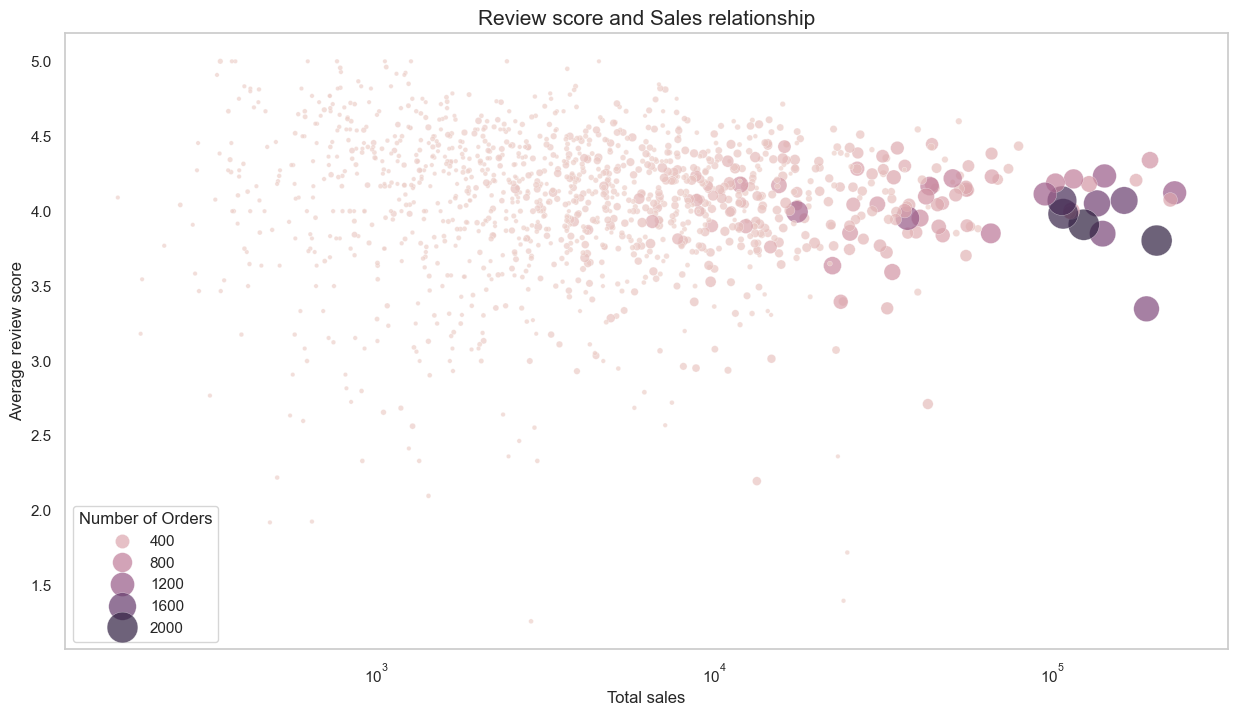

In [20]:
sellers = '''
SELECT 
    sellers.seller_id,
    AVG(order_reviews.review_score) AS avg_review_score,
    SUM(order_items.price) AS total_sales,
    COUNT(orders.order_id) AS num_orders
FROM 
    sellers
    LEFT JOIN order_items ON sellers.seller_id = order_items.seller_id
    LEFT JOIN orders ON order_items.order_id = orders.order_id
    LEFT JOIN order_reviews ON orders.order_id = order_reviews.order_id
GROUP BY sellers.seller_id
having num_orders > 10
order by total_sales DESC
'''

df_sellers = pd.read_sql_query(sellers, db_connection)
plt.figure(figsize=(15, 8))
sns.scatterplot(data=df_sellers, x='total_sales', y='avg_review_score', size='num_orders', sizes=(10, 500), 
                hue='num_orders', alpha=0.7)
plt.xscale('log')
plt.xlabel('Total sales')
plt.ylabel('Average review score')
plt.title('Review score and Sales relationship',fontdict={'fontsize':15})
plt.grid(False)
plt.legend(title='Number of Orders')
plt.show()


This scatter plot illustrates the relationship between total sales and average review scores, with the size and color intensity of the markers representing the number of orders. There is a general positive correlation, indicating that sellers with higher sales volumes tend to achieve higher review scores. A clear cluster of high performers is visible in the upper-right corner, where sellers with total sales exceeding 
1000 also maintain average review scores above 4.5. In contrast, sellers with lower sales volumes (10 to 100) exhibit a wide range of review scores, from as low as 1 to as high as 5, suggesting variability in customer satisfaction for this group. Interestingly, a few outliers with very high sales but lower review scores (around 3.5) highlight potential issues with customer satisfaction or product quality despite significant sales. Additionally, the largest and darkest markers, representing the highest number of orders, are concentrated in the high sales and high review score region, reinforcing the link between customer satisfaction and purchase frequency.

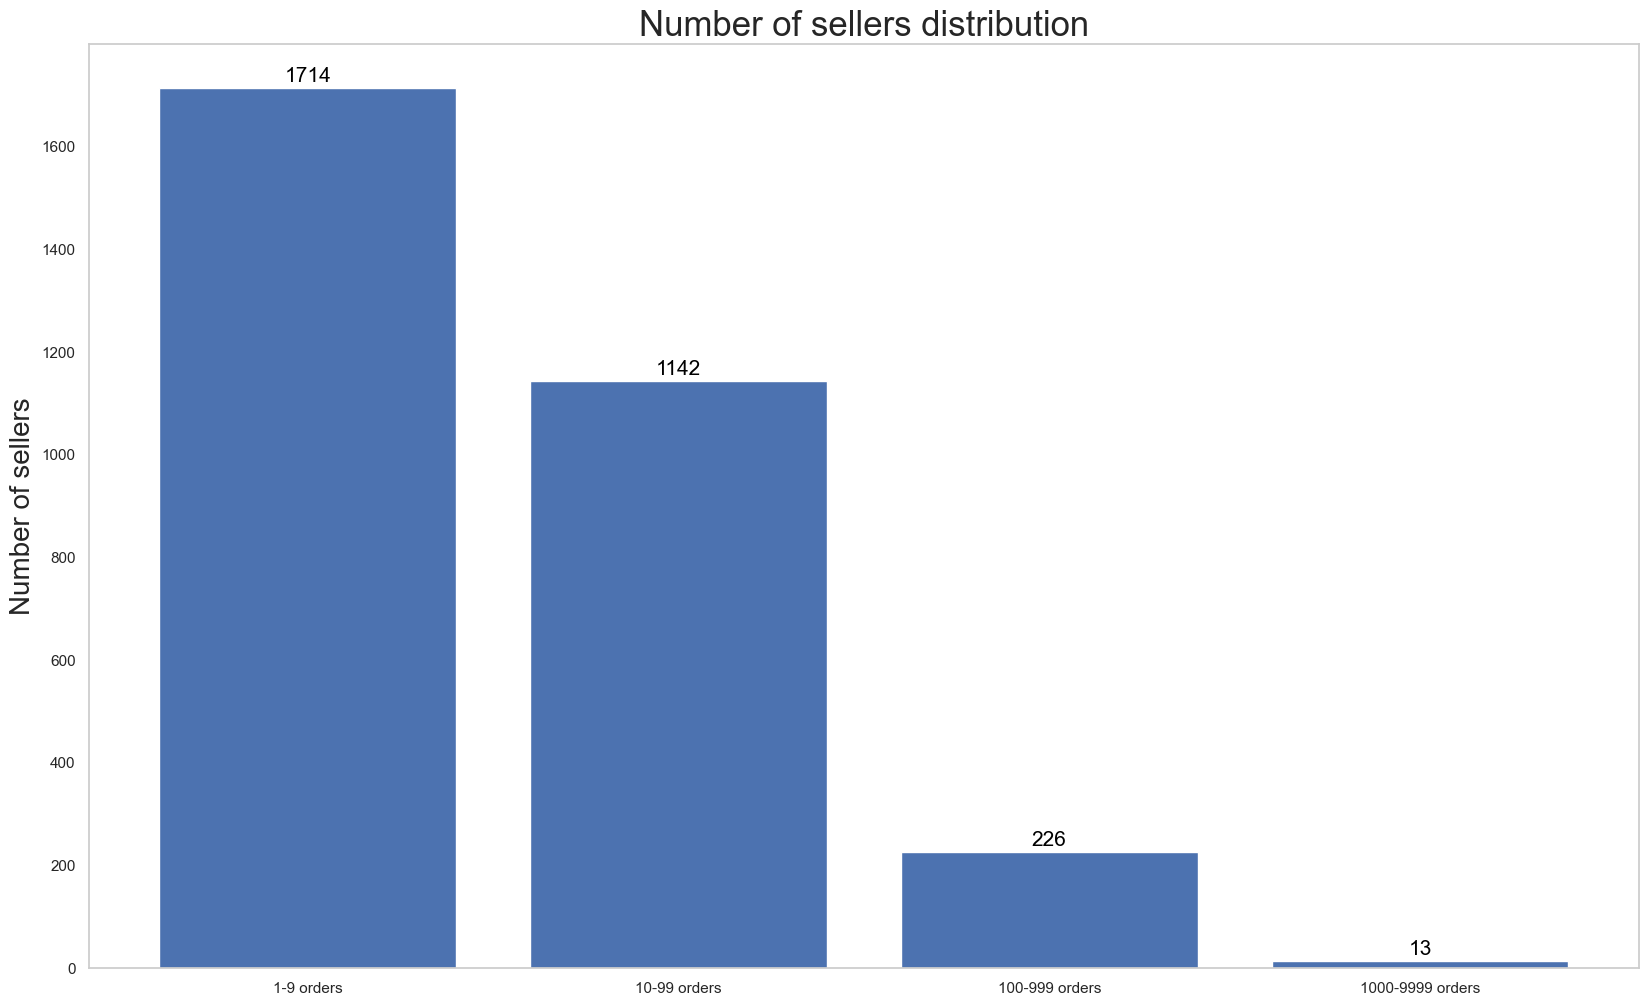

In [24]:
seller_bin = """select s.seller_id ,
count(s.seller_id) as number_of_order,
avg(oi.price) as avg_price
from sellers s 
left join order_items oi on oi.seller_id = s.seller_id 
group by s.seller_id
order by number_of_order desc
"""

df_seller_bin = pd.read_sql_query(seller_bin, db_connection)
# Define the bin edges explicitly
bins = [0, 9, 99, 999, 9999]  
group_names = ['1-9 orders', '10-99 orders', '100-999 orders', '1000-9999 orders']
# Use pd.cut to classify the sellers into these bins
df_seller_bin['Price-binned'] = pd.cut(
    df_seller_bin['number_of_order'], 
    bins=bins, 
    labels=group_names, 
    include_lowest=True
)
plt.figure(figsize=(20, 12))
bar_bin = plt.bar(group_names, df_seller_bin["Price-binned"].value_counts())
for bar in bar_bin:
    height = bar.get_height()
    plt.text(
        bar.get_x() + bar.get_width() / 2, 
        height + 5,  
        f'{int(height)}',  
        ha='center', 
        va='bottom', 
        fontsize=15,  
        color='black' 
    )
plt.xlabel("")
plt.ylabel("Number of sellers",fontdict={'fontsize':20})
plt.title("Number of sellers distribution",fontdict={'fontsize':25})
plt.grid(False)
plt.show()

The plot reveals a skewed distribution of sellers, with a significant majority concentrated in the low-order range (1-9 orders). This indicates a large number of sellers who are either new to the platform or operate on a small scale. As the order volume increases, the number of sellers declines sharply. Only a small fraction of sellers achieve high order volumes (1000-9999 orders), suggesting a challenging environment for achieving and maintaining substantial sales.

Our comprehensive analysis will aim to identify the customer group that demonstrates the highest average order value. This identification will be followed by a thorough investigation into the contribution of this specific group to the overall profitability of Olist's paltform.

In [28]:
total_seller = """select s.seller_id ,
count(s.seller_id) as number_of_order,
sum(oi.price) as sum_price
from sellers s 
left join order_items oi on oi.seller_id = s.seller_id 
group by s.seller_id
"""
df_seller_total = pd.read_sql_query(total_seller, db_connection)
bins = [0, 9, 99, 999, 9999]  
group_names = ['1-9 orders', '10-99 orders', '100-999 orders', '1000-9999 orders']
# Use pd.cut to classify the sellers into these bins
df_seller_total['Price-binned'] = pd.cut(
    df_seller_total['number_of_order'], 
    bins=bins, 
    labels=group_names, 
    include_lowest=True
)
total_seller_per_group = df_seller_total.groupby('Price-binned')['sum_price'].sum()
print(total_seller_per_group)



Price-binned
1-9 orders          1106098.16
10-99 orders        5204981.55
100-999 orders      5602412.33
1000-9999 orders    1678151.66
Name: sum_price, dtype: float64


C:\Users\minhn\AppData\Local\Temp\ipykernel_20288\220514284.py:18: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  total_seller_per_group = df_seller_total.groupby('Price-binned')['sum_price'].sum()


C:\Users\minhn\AppData\Local\Temp\ipykernel_20288\2255431999.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  average_sales_per_group = df_seller_bin.groupby('Price-binned')['avg_price'].mean()


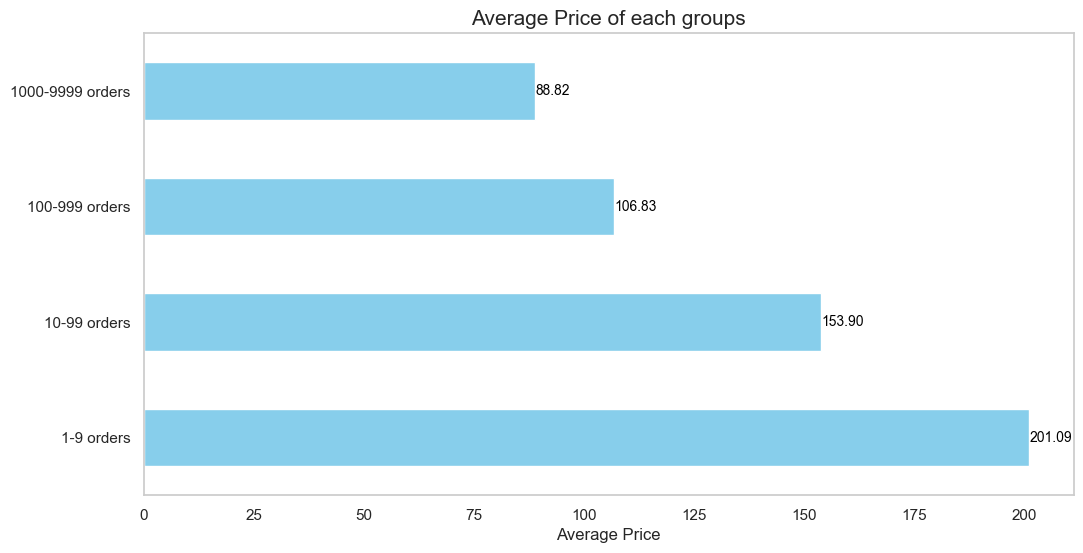

In [29]:
# Calculate the average sale (avg_price) for each bin
average_sales_per_group = df_seller_bin.groupby('Price-binned')['avg_price'].mean()
plt.figure(figsize=(12, 6))
average_sales_per_group.plot(kind='barh', figsize=(12, 6), color='skyblue')
for i, value in enumerate(average_sales_per_group):
    plt.text(
        value + 0.1,           
        i,                   
        f'{value:.2f}',        
        va='center', fontsize=10, color='black'
    )
plt.xlabel('Average Price', fontsize=12)
plt.ylabel('')
plt.title('Average Price of each groups', fontsize=15)
plt.grid(False)
plt.show()

Analysis reveals that sellers with the lowest order volume (1-9 orders) have the highest average order value (approximately 201). This likely indicates the use of various discount strategies and promotional campaigns to incentivize purchases from smaller customer segments. However, despite their smaller numbers, sellers with 10-99 and 100-999 orders generate the most revenue. These segments, representing roughly half and one-eighth of the total seller base respectively, are key contributors to overall platform success. To further optimize revenue generation, Olist should prioritize these two segments by implementing targeted incentive programs and enhancing delivery services to attract customers to their offerings. While high-volume sellers (1000+ orders) may have a slightly lower revenue contribution, they represent a stable and valuable revenue stream that should not be neglected.

# C. CONCLUSION

Our analysis of the Olist dataset provided valuable insights into the company’s operations. Olist demonstrated steady growth throughout the analyzed period, with a notable sales spike during the Christmas season. Sales trends revealed that certain product categories are expanding much faster than others. Customers tend to place orders more frequently at the beginning of the week, and the majority of sales are concentrated in highly populated cities, particularly Sao Paulo and Rio de Janeiro. Shipping durations vary widely across different locations and are occasionally impacted by postal strikes. While many customers leave positive reviews, shipping delays are a common source of complaints. Most orders are low in value, though order costs can vary significantly. The "Health and Beauty" category stands out as the most popular. Most Olist sellers are small businesses, which tend to offer slightly faster shipping times than larger sellers. 